In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtrans

## Automated but complicated ...
models_path = "/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/comparison_HCP_full/"
list_dir = os.listdir(models_path)
paths = [models_path + elem for elem in list_dir]

bdd_models = []

generate_bdd_models(paths, bdd_models=bdd_models, visited=[], dataset='cingulate_ACCpatterns_1')

In [2]:
##handmade AUC plots

#copy AUC values of the different models

ACC_adult_size = [0.726, 0.640, 0.681, 0.710, 0.750, 0.686, 0.699, 0.697] # SimCLR: Training HCP, SVM ACC adult crops

ACC_baby_size = [0.631, 0.675, 0.499, 0.558, 0.677, 0.619, 0.492, 0.550] # SimCLR: Training HCP, SVM ACC baby crops ## Used to test padding (vs resize)
Preterm_baby_size = [0.525, 0.587, 0.698, 0.619, 0.660, 0.591, 0.653, 0.671] # SimCLR: Training HCP, SVM Preterm baby crops ## Used to test padding (vs resize)
ACC_resize = [0.756, 0.707, 0.730, 0.754, 0.732, 0.715, 0.715, 0.719] # SimCLR: Training HCP, Adult crops resized to baby crops size, SVM ACC
Preterm_resize = [0.533, 0.641, 0.512, 0.517, 0.501, 0.453, 0.479, 0.588] # SimCLR: Training HCP, Adult crops resized to baby crops size, SVM Preterm # WEIRD RESULTS, MAYBE SOMETHING WRONG
#ACC_baby_crop = [0.633, 0.566, 0.546, 0.602, 0.558] #the crops were wrong
#Preterm_baby_crop = [0.815, 0.542, 0.509, 0.659, 0.488] #the crops were wrong

ACC_new_crop = [0.714, 0.681, 0.674, 0.754, 0.735, 0.716, 0.648, 0.680, 0.718] # SimCLR HCP, SVM ACC, using new crops
Preterm_new_crop = [0.613, 0.651, 0.647, 0.583, 0.624, 0.687, 0.637, 0.599, 0.689] # SimCLR HCP, SVM Preterm, using new crops
Preterm_new_crop_shuffle = [0.479, 0.455, 0.577, 0.521, 0.506, 0.492, 0.492, 0.470, 0.520] # Same as previous, randomly shuffled labels

Supervised_preterm_lr_low = [0.919, 0.889, 0.682, 0.879, 0.889] # Supervised Preterm (using 75/25 partition for train+val/test) lr=1e-4
Supervised_preterm_lr_high = [0.798, 0.884, 0.763, 0.874, 0.692] # Same but lr=1e-3 #not plotted for now, seems similar
ACC_Supervised_preterm_lr_low = []

SimCLR_Preterm = [0.699, 0.751, 0.711, 0.751, 0.718] # SimCLR Preterm, SVM Preterm test
SimCLR_Preterm_ACC = [0.664, 0.665, 0.674, 0.663, 0.687] # SimCLR Preterm, SVM ACC
Pretrain_HCP_ACC = [0.742, 0.738, 0.742, 0.702, 0.674] # SimCLR HCP as pretraining, then SimCLR Preterm, SVM ACC
Pretrain_HCP_Preterm = [0.625, 0.753, 0.662, 0.734, 0.589] # SimCLR HCP as pretraining, then SimCLR Preterm, SVM Preterm

Pretrain_Preterm_ACC = [0.696, 0.621, 0.648, 0.710, 0.667]
Pretrain_Preterm_Preterm = [0.692, 0.455, 0.577, 0.509, 0.554]

dict_plot_adult = {"Adult crop \nInput Size: 17x40x38 \nCrop Size: 17x40x38": ACC_adult_size,
                   "Baby input size \nInput Size: 21x48x49 \nCrop Size: 17x40x38": ACC_baby_size,
                   "New crop \nInput Size: 16x36x37 \nCrop Size: 16x36x37": ACC_new_crop,
                   "Resize": ACC_resize,
                   "Supervised": [np.nan]}

dict_plot_40wks = {"Adult crop \nInput Size: 17x40x38 \nCrop Size: 17x40x38": [np.nan],
                   "Baby input size \nInput Size: 21x48x49 \nCrop Size: 21x48x49": Preterm_baby_size,
                   "New crop \nInput Size: 16x36x37 \nCrop Size: 16x36x37": Preterm_new_crop,
                   "Resize": Preterm_resize,
                   "Supervised": Supervised_preterm_lr_low}

#shuffle preterm labels to show intrinsic variability
dict_plot_shuffle_labels = {"Adult crop \nInput Size: 17x40x38 \nCrop Size: 17x40x38": [np.nan],
                            "Baby input size \nInput Size: 21x48x49 \nCrop Size: 21x48x49": [np.nan],
                            "New crop \nInput Size: 16x36x37 \nCrop Size: 16x36x37": Preterm_new_crop_shuffle,
                            "Resize": [np.nan],
                            "Supervised": [np.nan]}


# Load baseline AUCs (lower bound, PCA)
# PCA trained on HCP_full, applied to preterm dataset to get embeddings in a very simple way
with open('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/PCA/HCP_full_preterm/values.json') as f:
    AUC_pca_hcp_preterm = json.load(f)
    AUC_pca_hcp_preterm = AUC_pca_hcp_preterm['cross_val_auc'][0]
# Same but "supervised" version. The training is done with train_val preterm, and the embeddings are computed on preterm test set
with open('/neurospin/dico/jlaval/Runs/01_deep_supervised/Program/Output/PCA/Preterm_Preterm_test/values.json') as f:
    AUC_pca_preterm_preterm_test = json.load(f)
    AUC_pca_preterm_preterm_test = AUC_pca_preterm_preterm_test['cross_val_auc'][0]

In [3]:
#reformat dictionnaries into dataframes for seaborn

def reformat(dict_plot, xlabel):

        df = pd.DataFrame({xlabel: [], 'AUC': []})
        for model, list_values in dict_plot.items():
            for value in list_values:
                new_row = {xlabel: model, 'AUC': value}
                df = df.append(new_row, ignore_index=True)
        
        return df

In [12]:
#plot all models (require to merge the group the dataframes in a dictionnary)

def plot_models_perf(dict_to_plot,
                    save_dir,
                    title,
                    xlabel,
                    legend_title='',
                    save_fig=True,
                    normalize=True):

    #erase previous plot
    plt.close()

    #legend
    patches=[]
    for name, (_, color) in dict_to_plot.items():
        patch = mpatches.Patch(color=color, label=name)
        patches.append(patch)

    #plot
    fig,ax = plt.subplots(figsize=(8,6))

    for idx, (name, (df, color)) in enumerate(dict_to_plot.items()):
        #tr = offset_plot(idx*3, fig=fig)
        sns.pointplot(data=df, x=xlabel, y='AUC', color=color, markers='s', linestyles='', ax=ax).set(title=title)
        sns.stripplot(data=df, x=xlabel, y='AUC', color=color, marker='v', ax=ax)

    #offset the distributions for a same model
    nb_test_sets = len(dict_to_plot.keys())
    for idx in range(nb_test_sets):
        offset = mtrans.ScaledTranslation(0.15*idx, 0, ax.figure.dpi_scale_trans)
        nb_coll = len(ax.collections)
        start_offset_idx, end_offset_idx = idx*nb_coll // nb_test_sets, (idx+1)*nb_coll // nb_test_sets
        for k in range(start_offset_idx, end_offset_idx): #don't really understand the collection organization
            #first offset the points
            trans = ax.collections[k].get_transform()
            ax.collections[k].set_transform(trans + offset)
            #offset the errorbars
            trans = ax.lines[k].get_transform()
            ax.lines[k].set_transform(trans + offset)
    if normalize:
        ax.set_ylim([0.45, 1])
    #plt.legend(handles=patches, title=legend_title)
    plt.xticks(rotation=0, fontsize=13)
    ax.set_xlabel('Model', fontsize=15)
    ax.set_ylabel('AUC', fontsize=15)
    if save_fig:
        plt.savefig(save_dir, facecolor='white')
    plt.show()

## plot all perf # OBSOLETE

#reformat the dictionnaries
df_adult = reformat(dict_plot_adult)
df_40wks = reformat(dict_plot_40wks)
df_shuffle_labels = reformat(dict_plot_shuffle_labels)

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"Adult": [df_adult, 'darkred'],
                "40wks": [df_40wks, 'steelblue'],
                "40wks labels shuffled": [df_shuffle_labels, 'black']}

#plot and save model
save_dir = '/home/jl274628/Images/Comparison_AUCs_all.png'
plot_models_perf(dict_to_plot, save_dir, save_fig=True)

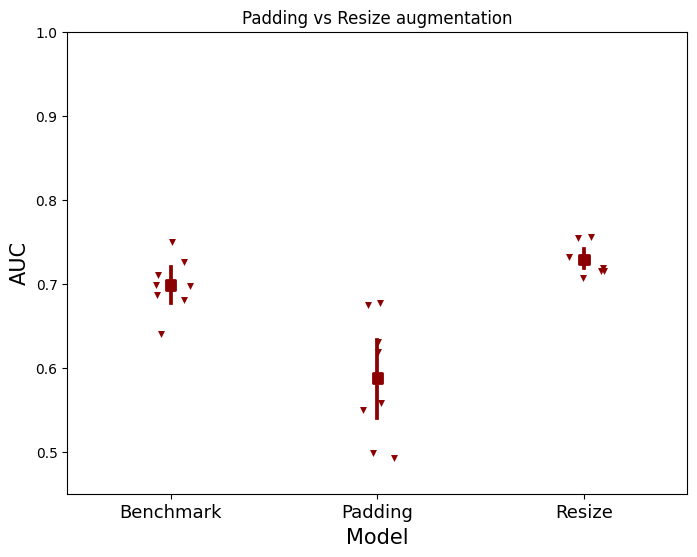

In [13]:
# Resize vs padding #DONE
dict_plot_adult = {"Benchmark": ACC_adult_size,
                   "Padding": ACC_baby_size,
                   "Resize": ACC_resize}

xlabel='Model'
title='Padding vs Resize augmentation'
save_dir = '/home/jl274628/Images/AUCs_padding_vs_resize.png'

####
df_adult = reformat(dict_plot_adult, xlabel)

dict_to_plot = {"ACC": [df_adult, 'darkred']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 save_fig=True)

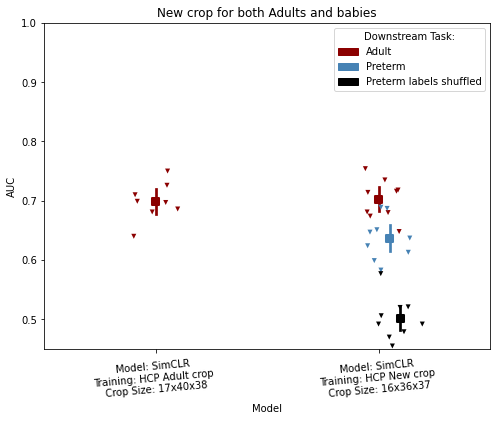

In [84]:
# New crop works well on ACC # DONE
dict_plot_adult = {"HCP Adult crop \nCrop Size: 17x40x38": ACC_adult_size,
                   "HCP New crop \nCrop Size: 16x36x37": ACC_new_crop}

dict_plot_40wks = {"HCP Adult crop \nCrop Size: 17x40x38": [np.nan],
                   "HCP New crop \nCrop Size: 16x36x37": Preterm_new_crop}

#shuffle preterm labels to show intrinsic variability
dict_plot_shuffle_labels = {"Model: SimCLR \nTraining: HCP Adult crop \nCrop Size: 17x40x38": [np.nan],
                            "Model: SimCLR \nTraining: HCP New crop \nCrop Size: 16x36x37": Preterm_new_crop_shuffle}

xlabel='Model'
title='New crop for both Adults and babies'
save_dir = '/home/jl274628/Images/AUCs_new_crop.png'

####
df_adult = reformat(dict_plot_adult, xlabel)
df_40wks = reformat(dict_plot_40wks, xlabel)
df_shuffle_labels = reformat(dict_plot_shuffle_labels, xlabel)

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"Adult": [df_adult, 'darkred'],
                "Preterm": [df_40wks, 'steelblue'],
                "Preterm labels shuffled": [df_shuffle_labels, 'black']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 legend_title='Downstream Task:',
                 save_fig=True)

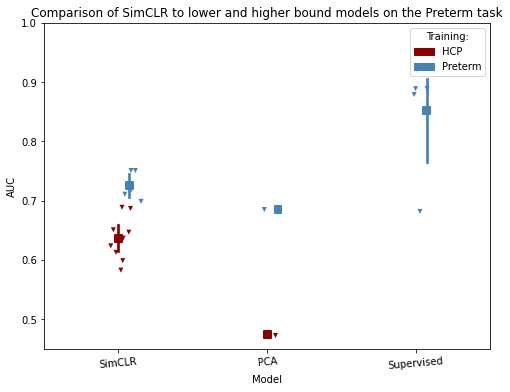

In [85]:
# Preterm task for SimCLR and reference models (PCA for lower bound and supervised for higher bound)
Preterm = {'SimCLR': SimCLR_Preterm,
           'PCA': [AUC_pca_preterm_preterm_test],
           'Supervised': Supervised_preterm_lr_low}

HCP = {'SimCLR': Preterm_new_crop,
       'PCA': [AUC_pca_hcp_preterm],
       'Supervised': [np.nan]}

xlabel='Model'
title='Comparison of SimCLR to lower and higher bound models on the Preterm task'
save_dir = '/home/jl274628/Images/AUCs_SimCLR_vs_bounds.png'

df_HCP = reformat(HCP, xlabel)
df_Preterm = reformat(Preterm, xlabel)

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"HCP": [df_HCP, 'darkred'],
                "Preterm": [df_Preterm, 'steelblue']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 legend_title='Training:',
                 save_fig=True)

## Pretraining experiments

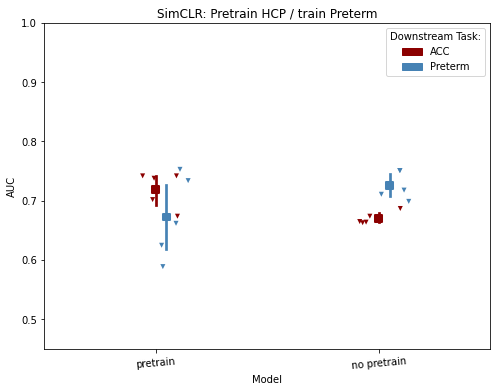

In [86]:
# Pretrain with SimCLR, post train with SimCLR, comparison to simple SimCLR
# Two plots: HCP then Preterm and vice versa

#1.
ACC = {'pretrain': Pretrain_HCP_ACC,
       'no pretrain': SimCLR_Preterm_ACC}

Preterm = {'pretrain': Pretrain_HCP_Preterm,
           'no pretrain': SimCLR_Preterm}

xlabel='Model'
title='SimCLR: Pretrain HCP / train Preterm'
save_dir = '/home/jl274628/Images/AUCs_pretrain_SimCLR_HCP.png'
legend_title='Downstream Task:'

df_ACC = reformat(ACC, xlabel)
df_Preterm = reformat(Preterm, xlabel)

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"ACC": [df_ACC, 'darkred'],
                "Preterm": [df_Preterm, 'steelblue']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 legend_title,
                 save_fig=True)


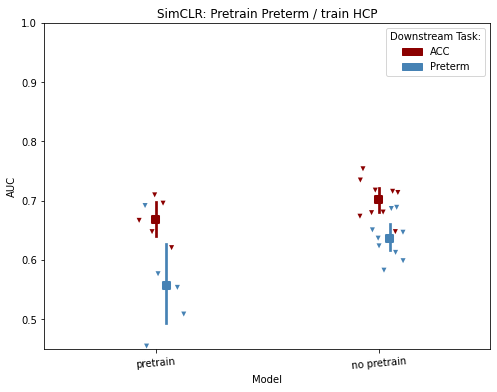

In [87]:
#2.
ACC = {'pretrain': Pretrain_Preterm_ACC,
       'no pretrain': ACC_new_crop}

Preterm = {'pretrain': Pretrain_Preterm_Preterm,
           'no pretrain': Preterm_new_crop}

xlabel='Model'
title='SimCLR: Pretrain Preterm / train HCP'
save_dir = '/home/jl274628/Images/AUCs_pretrain_SimCLR_Preterm.png'
legend_title='Downstream Task:'

df_ACC = reformat(ACC, xlabel)
df_Preterm = reformat(Preterm, xlabel)

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"ACC": [df_ACC, 'darkred'],
                "Preterm": [df_Preterm, 'steelblue']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 legend_title,
                 save_fig=True)

In [ ]:
# Same as before but the post train is supervised, comparison to simple supervised

#1.
ACC = {'pretrain':,
       'no pretrain': ACC_Supervised_preterm_lr_low}

Preterm = {'pretrain':,
           'no pretrain': Supervised_preterm_lr_low}

xlabel='Model'
title='SimCLR: Pretrain HCP / train Preterm'
save_dir = '/home/jl274628/Images/AUCs_pretrain_SimCLR_HCP.png'
legend_title='Downstream Task:'

df_HCP = reformat(HCP, xlabel)
df_Preterm = reformat(Preterm, xlabel)

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"ACC": [df_HCP, 'darkred'],
                "Preterm": [df_Preterm, 'steelblue']}

#plot and save model
plot_models_perf(dict_to_plot,
                 save_dir,
                 title,
                 xlabel,
                 legend_title,
                 save_fig=True)

## OBSOLETE

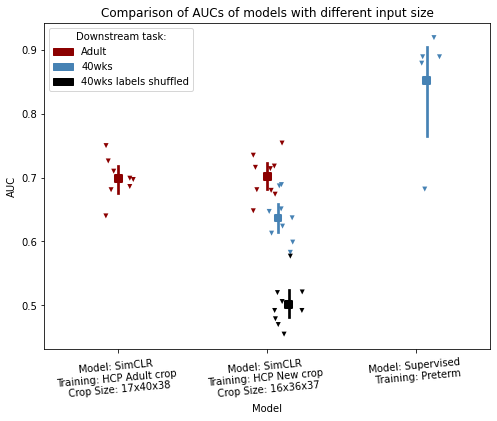

In [41]:
dict_plot_adult = {"HCP Adult crop \nCrop Size: 17x40x38": ACC_adult_size,
                   "HCP New crop \nCrop Size: 16x36x37": ACC_new_crop,
                   "Supervised Preterm": [np.nan]}

dict_plot_40wks = {"HCP Adult crop \nCrop Size: 17x40x38": [np.nan],
                   "HCP New crop \nCrop Size: 16x36x37": Preterm_new_crop,
                   "Supervised Preterm": Supervised_preterm_lr_low}

#shuffle preterm labels to show intrinsic variability
dict_plot_shuffle_labels = {"Model: SimCLR \nTraining: HCP Adult crop \nCrop Size: 17x40x38": [np.nan],
                            "Model: SimCLR \nTraining: HCP New crop \nCrop Size: 16x36x37": Preterm_new_crop_shuffle,
                            "Model: Supervised \n Training: Preterm": [np.nan]}

df_adult = reformat(dict_plot_adult, 'Model')
df_40wks = reformat(dict_plot_40wks, 'Model')
df_shuffle_labels = reformat(dict_plot_shuffle_labels, 'Model')

#group the dataframes in a dictionnary, input for plotting function
dict_to_plot = {"Adult": [df_adult, 'darkred'],
                "40wks": [df_40wks, 'steelblue'],
                "40wks labels shuffled": [df_shuffle_labels, 'black']}

# Add the supervised model: two different learning rates used

#plot and save model
save_dir = '/home/jl274628/Images/Comparison_AUCs_new_crop.png'
plot_models_perf(dict_to_plot,
                 save_dir,
                 xlabel='Model',
                 save_fig=False)